# 2024-01-26 DEV: dataset alignment and validation


**Goal**: develop a class of methods to load in old and new datasets for an animal and produce figures to ensure alignment and explain any variation in model results that may occur. 

See the explore_W078 version of this notebook for the initial analyses related timeout (non-engage) trials and violations

## Load in (note first NB with package use!)

In [20]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


from multiglm.data.get_rat_data import *

sns.set_context("talk")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
from multiglm.data.dataset_alignmnet import DatasetLoadAndAlign

t = DatasetLoadAndAlign("W075")
t.run()

** RUNNING W075 **
returning full data for W075
returning truncated viol data for W075
alignment data already exists for W075
returning new data for W075
returning new data with no touts for W075
alignment summary data across dfs already computed for W075


In [34]:
from multiglm.data.dataset_alignmnet import DatasetVisualizer

viz = DatasetVisualizer(t)

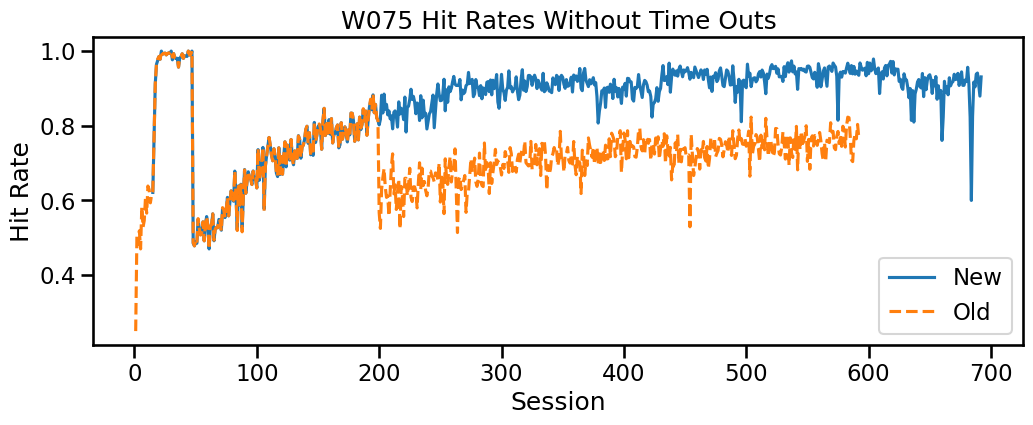

In [35]:
viz.plot_hit_rates()

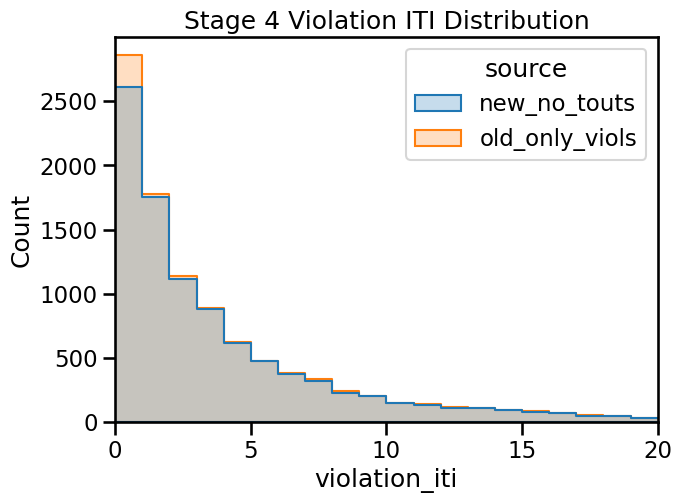

In [36]:
viz.plot_violation_iti()

In [37]:
def make_mega_alignment_figure(
    alignment_obj,
    save_out=False,
    save_path="../figures/dataset_alignment/",
):
    viz = DatasetVisualizer(alignment_obj)
    animal_id = alignment_obj.animal_id

    # Make Figure
    layout = """
              AABBCCCC
              DDDDEEEE
              FFFFGGGG
              HHIIJJKK
       """
    fig = plt.figure(constrained_layout=True, figsize=(20, 17))
    ax_dict = fig.subplot_mosaic(layout)  # ax to plot to
    plt.suptitle(f"{animal_id} Dataset Alignment Summary Plot", fontweight="semibold")

    ## ROW 1 ##
    viz.plot_n_sessions(ax=ax_dict["A"])
    viz.plot_n_trials_per_session(ax=ax_dict["B"])
    viz.plot_timeout_rates(ax=ax_dict["C"])

    ## ROW 2 ##
    viz.plot_trial_counts(with_touts=True, ax=ax_dict["D"])
    viz.plot_violation_rates(with_touts=False, ax=ax_dict["E"])

    ## ROW 3 ##
    viz.plot_hit_rates(ax=ax_dict["F"])
    viz.plot_violation_rates(with_touts=True, ax=ax_dict["G"])

    ## ROW 4 ##
    viz.plot_viol_rate_per_session_all_stages(ax=ax_dict["H"])
    viz.plot_viol_rate_per_session_stage_4(ax=ax_dict["I"])
    viz.plot_violation_iti(ax=ax_dict["J"])

    if save_out:
        plt.savefig(save_path + f"{animal_id}_alignment_mega_fig", bbox_inches="tight")
        print(f"figure saved for {animal_id}")
        plt.close("all")

    return None

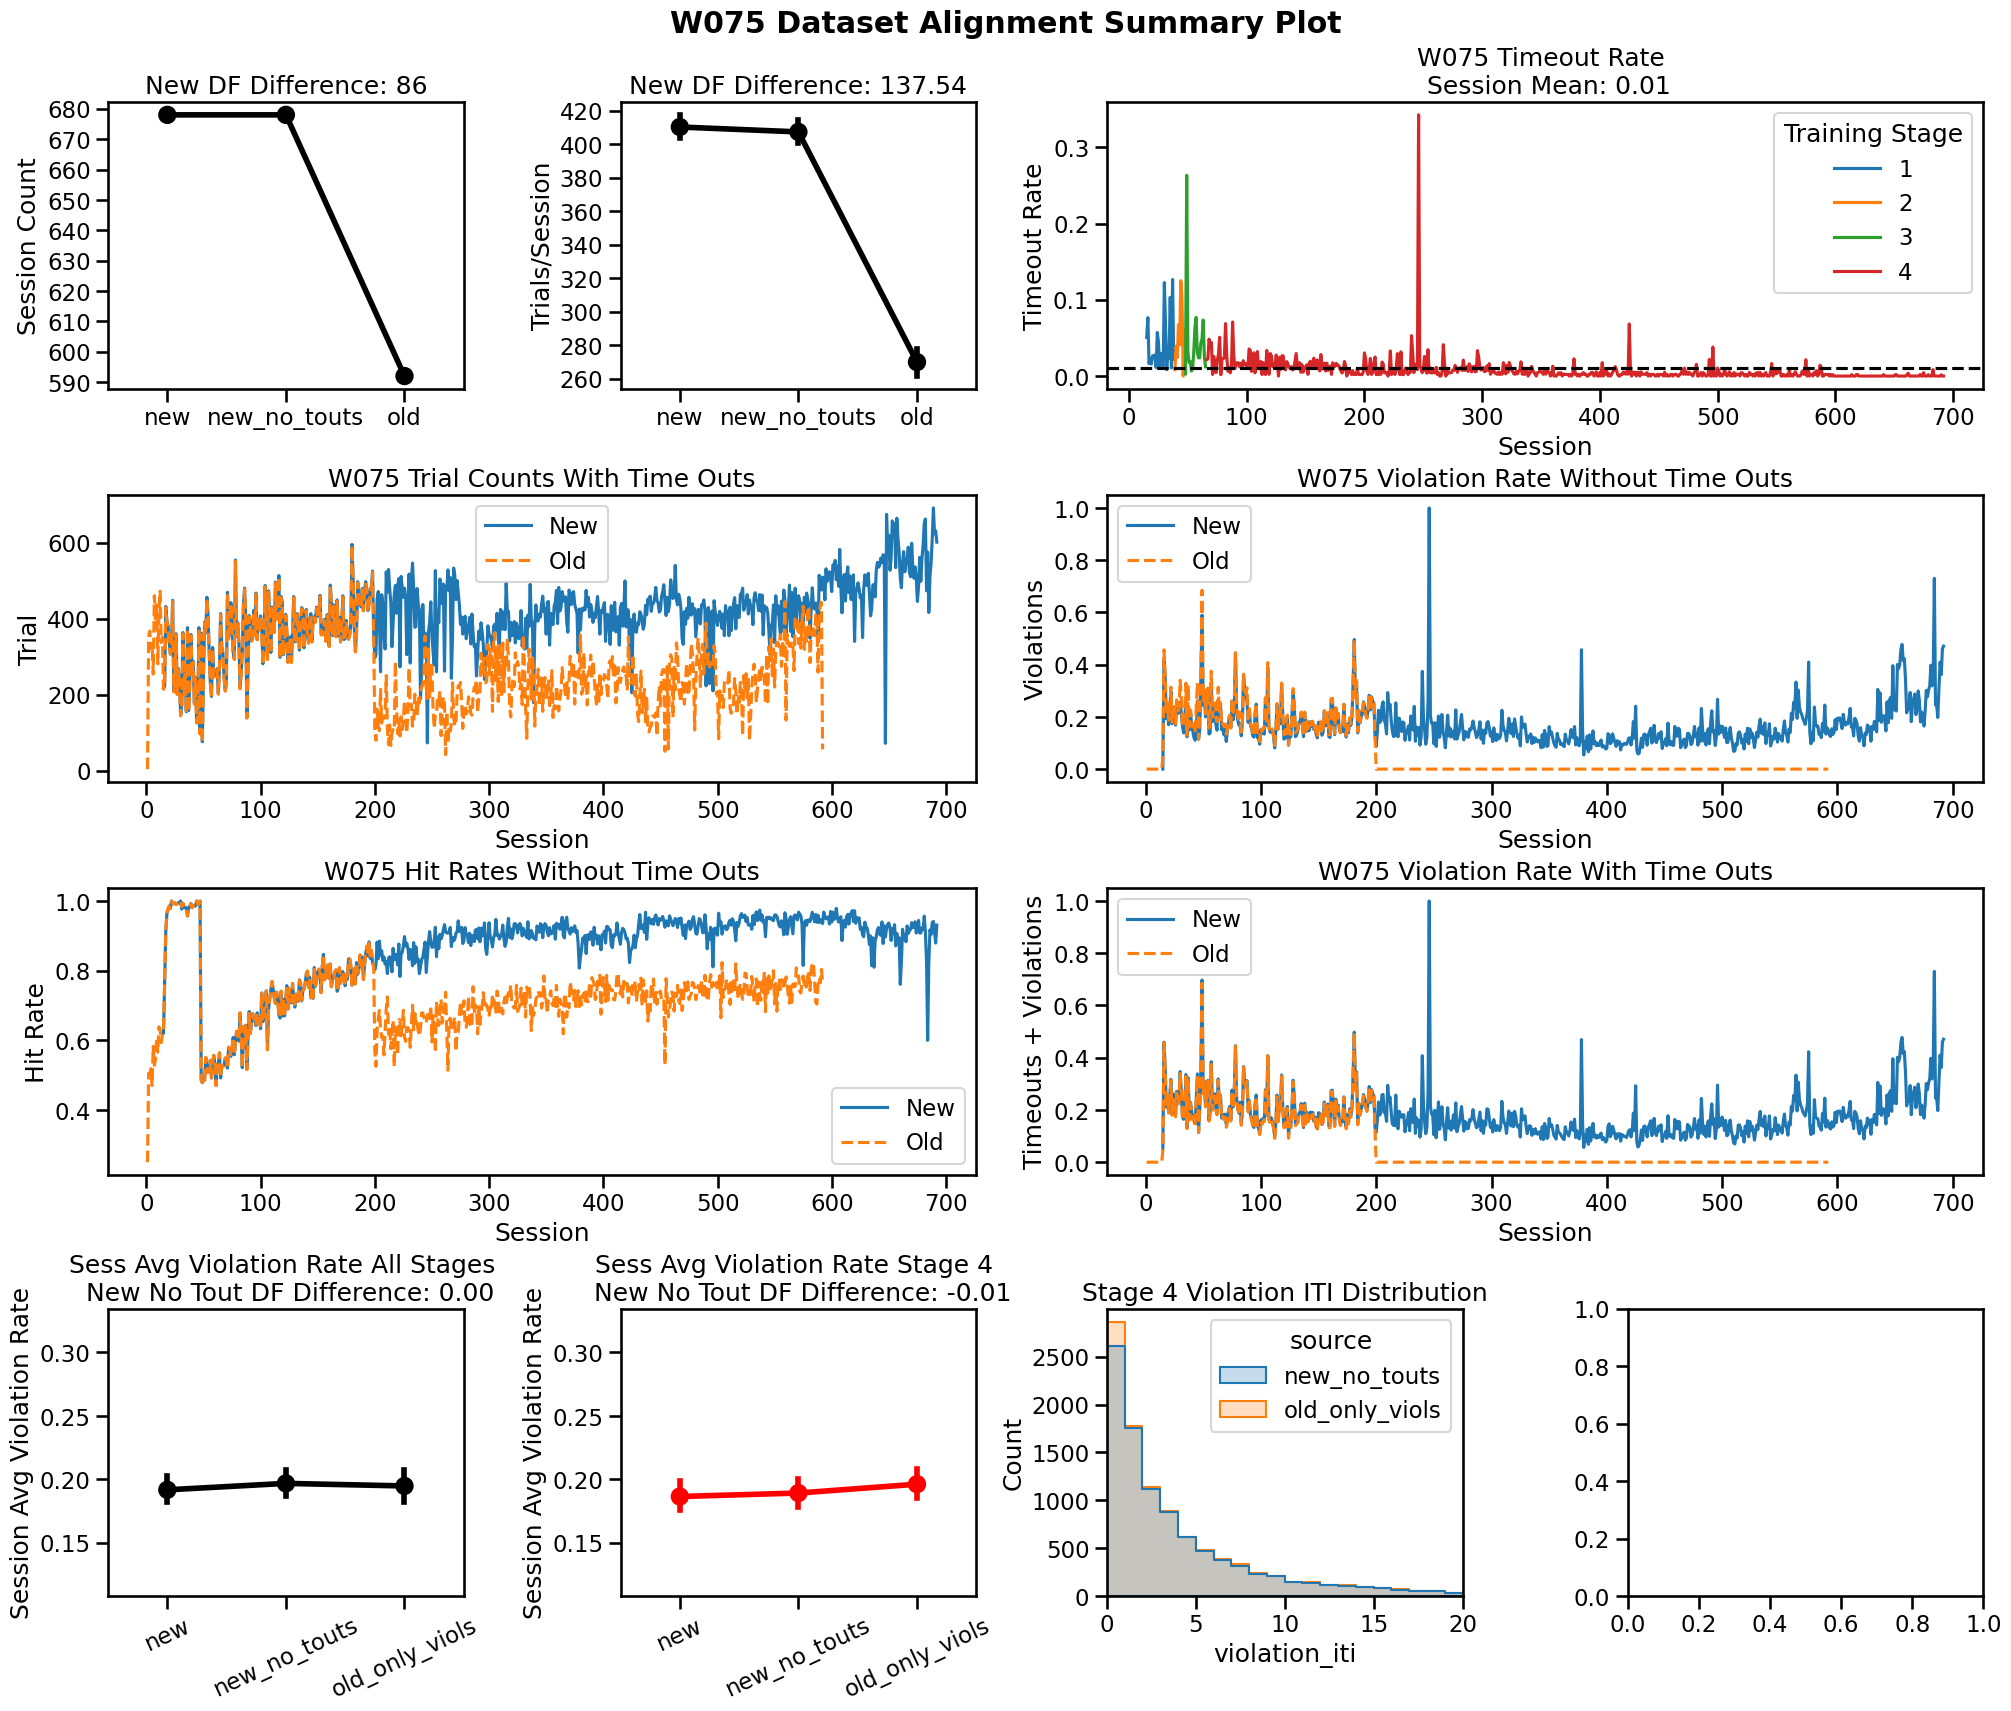

In [38]:
make_mega_alignment_figure(t)

In [39]:
make_mega_alignment_figure(t, save_out=True)

figure saved for W075


In [40]:
def run_and_visualize_alignment(animal_ids, save_out=True):
    for animal_id in animal_ids:
        align = DatasetLoadAndAlign(animal_id)
        align.run()
        make_mega_alignment_figure(align, save_out=save_out)
    return None

In [41]:
animal_ids = ["W078", "W075"]

run_and_visualize_alignment(animal_ids, save_out=True)

** RUNNING W078 **
returning full data for W078
returning truncated viol data for W078
new to old alignment df created containing W078
returning new data for W078
returning new data with no touts for W078
saved alignment summary data across dfs for W078
figure saved for W078
** RUNNING W075 **
returning full data for W075
returning truncated viol data for W075
new to old alignment df created containing W075
returning new data for W075
returning new data with no touts for W075
saved alignment summary data across dfs for W075
figure saved for W075


TODO


- read in alignment data and merge
- create summary fig of alignment

In [24]:
animals = ["W051", "W060", "W062"]
import pandas as pd
import seaborn as sns

sns.set_context("talk")

dfs = []
for animal_id in animals:
    dfs.append(
        pd.read_csv(f"../data/processed/dataset_alignment/{animal_id}_alignment_df.csv")
    )

alignment_all_animals = pd.concat(dfs, axis=0)

alignment_all_animals.head(8)

,animal_id,source,max_trial,align_session,n_sessions,n_trials_per_session,session_avg_violation,session_avg_violation_stage_4
0,W051,new,446.0,61.0,604,163.298013,0.155001,0.136250
1,W051,old,443.0,61.0,590,149.939104,0.183063,0.166728
2,W051,new_no_touts,NaN,NaN,599,161.646077,0.177480,0.163597
3,W051,old_only_viols,NaN,NaN,196,159.599490,0.185865,0.170108
0,W060,new,479.0,67.0,492,158.085366,0.153755,0.119455
1,W060,old,476.0,75.0,498,141.042169,0.191715,0.158175
2,W060,new_no_touts,NaN,NaN,491,152.194501,0.172263,0.135655
3,W060,old_only_viols,NaN,NaN,199,139.055276,0.191715,0.158175


In [59]:
class PostAlignmentVisualizer:
    def __init__(self, animal_ids):
        self.animal_ids = animal_ids
        self.alignment_df = self.load_and_concat()

    def load_and_concat(self):
        dfs = []
        for animal_id in self.animal_ids:
            dfs.append(
                pd.read_csv(
                    f"../data/processed/dataset_alignment/{animal_id}_alignment_df.csv"
                )
            )
        return pd.concat(dfs, axis=0, ignore_index=True)

    def compute_and_plot_delta(self, source_a, source_b, column_name, ax=None):
        delta_df = self.compute_df_delta(source_a, source_b, column_name)

        self.plot_deltas(source_a, source_b, column_name, delta_df, ax=ax)

        return None

    def compute_df_delta(self, source_a, source_b, column_name):
        assert (
            column_name in self.alignment_df.columns
        ), f"{column_name} column not in df"
        delta_df = (
            self.alignment_df.groupby("animal_id")
            .apply(
                lambda group: self.calculate_delta(
                    group, source_a, source_b, column_name
                )
            )
            .reset_index(name=f"delta_{column_name}")
        )
        return delta_df

    @staticmethod
    def calculate_delta(group, source_a, source_b, column_name):
        a_value = group[group["source"] == source_a][column_name].values
        b_value = group[group["source"] == source_b][column_name].values
        # Ensure both values are present before calculating delta
        if len(a_value) > 0 and len(b_value) > 0:
            return a_value[0] - b_value[0]
        else:
            return None  # Return None if one of the sources is missing for the animal

    @staticmethod
    def plot_deltas(source_a, source_b, column_name, delta_df, ax=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 5))

        delta_df.plot(
            x="animal_id", y=f"delta_{column_name}", kind="bar", ax=ax, legend=False
        )

        ax.axhline(0, color="k")

        ax.set(
            title=f"{source_a} {column_name} delta",
            ylabel=f"$\Delta$ {source_a} - {source_b}",
        )

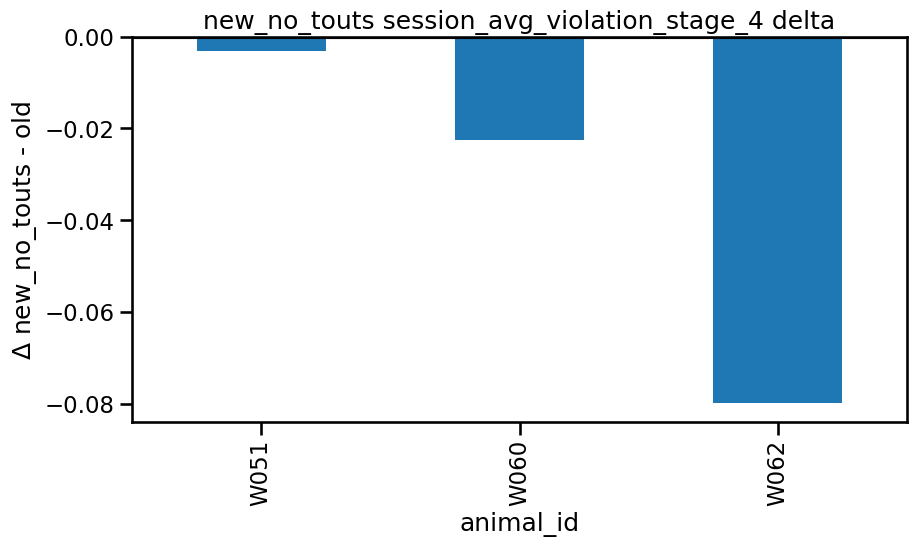

In [60]:
animals = ["W051", "W060", "W062"]
viz2 = PostAlignmentVisualizer(animals)

viz2.compute_and_plot_delta("new_no_touts", "old", "session_avg_violation_stage_4")

In [ ]:
def compute_and_plot_deltas(df, source_a, source_b, column_name)

In [16]:
def compute_df_deltas(df, source_a, source_b, column_name):
    def _calculate_delta(group, source_a, source_b, column_name):
        a_value = group[group["source"] == source_a][column_name].values
        b_value = group[group["source"] == source_b][column_name].values
        # Ensure both values are present before calculating delta
        if len(a_value) > 0 and len(b_value) > 0:
            return a_value[0] - b_value[0]
        else:
            return None  # Return None if one of the sources is missing for the animal

    delta_df = (
        df.groupby("animal_id")
        .apply(lambda group: _calculate_delta(group, source_a, source_b, column_name))
        .reset_index(name=f"delta_{column_name}")
    )

    return delta_df

In [36]:
delta_df = compute_df_deltas(alignment_all_animals, "new", "old", "n_sessions")

In [39]:
def plot_deltas(source_a, source_b, column_name, delta_df, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))

    delta_df.plot(
        x="animal_id", y=f"delta_{column_name}", kind="bar", ax=ax, legend=False
    )

    ax.axhline(0, color="k")

    ax.set(
        title=f"{source_a} {column_name} delta",
        ylabel=f"$\Delta$ {source_a} - {source_b}",
    )

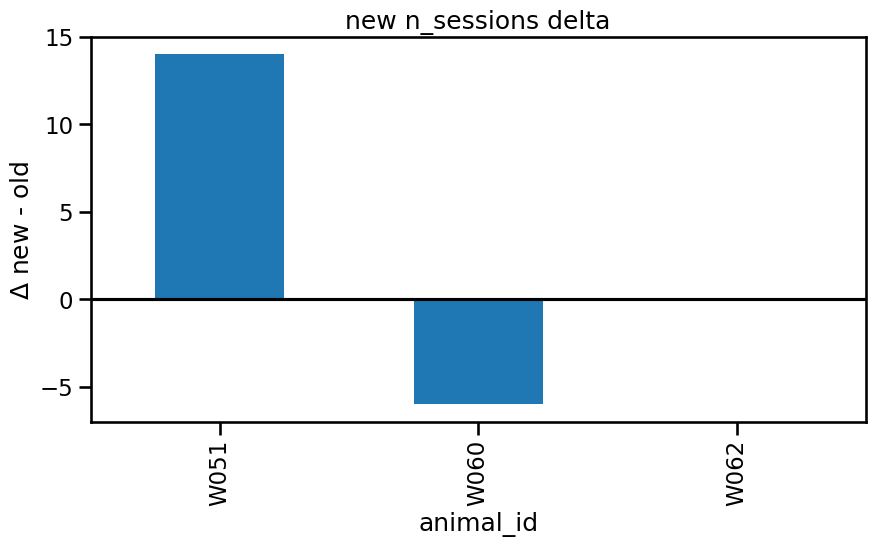

In [40]:
plot_deltas("new", "old", "n_sessions", delta_df)

In [ ]:
# new - old, n_sessions
# new_no_touts - old, n_trials_per_session
# new_no_touts - old_viol_only, session_avg_violation
# new_no_touts - old_viol_only, session_avg_violation_stage_4

